# Explorando los datasets

## Imports

In [1]:
from os import listdir, mkdir
from shutil import move, copy
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from IPython.display import display


## Kaggle Diabetic Retinopathy Classification

### Cropped train labels

 Load the dataset

In [ ]:
df = pd.read_csv('./Daniel-files/PracticasProfesionales/Data/Raw/DrClassification/KaggleDrDetection/trainLabels_cropped.csv')

df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
display(df.groupby('level').count())

plt.pie([df.loc[df['level'] == n].count()[0] for n in range(5)], labels = range(5), autopct='%.2f %%')
plt.title("Levels of DR in the dataset")

Undersampling to balance the dataset

In [ ]:
balanced_df = df.groupby('level').sample(708)

balanced_df.reset_index(drop=True, inplace=True)

display(balanced_df.groupby('level').count())

plt.pie([balanced_df.loc[balanced_df['level'] == n].count()[0] for n in range(5)], labels = range(5), autopct='%.2f %%')
plt.title("Levels of DR in the dataset")



In [ ]:
balanced_df.to_csv('./Daniel-files/PracticasProfesionales/Data/Raw/DrClassification/KaggleDrDetection/trainLabels_cropped_balanced.csv', index_label='index')

### Train labels

Load the dataset

In [ ]:
df = pd.read_csv('./Daniel-files/PracticasProfesionales/Data/Raw/DrClassification/KaggleDrDetection/trainLabels.csv')

display(df.groupby('level').count())

plt.pie([df.loc[df['level'] == n].count()[0] for n in range(5)], labels = range(5), autopct='%.2f %%')
plt.title("Levels of DR in the dataset")

Undersampling to balance the dataset

In [ ]:
balanced_df = df.groupby('level').sample(708)

balanced_df.reset_index(drop=True, inplace=True)

display(balanced_df.groupby('level').count())

plt.pie([balanced_df.loc[balanced_df['level'] == n].count()[0] for n in range(5)], labels = range(5), autopct='%.2f %%')
plt.title("Levels of DR in the dataset")



In [ ]:
balanced_df.to_csv('./Daniel-files/PracticasProfesionales/Data/Raw/DrClassification/KaggleDrDetection/trainLabels_balanced.csv', index_label='index')

## Messidor Diabetic Retinopathy

### DR Classification

In [2]:
bd = "./Data/Raw/VariedDrAndres/Messidor/BD1"
messidor = './DB/'
column = 'Retinopathy grade'

In [ ]:
!mkdir './DB/'

zipfiles = (f for f in listdir(bd) if f.endswith('.zip') == True)
for z in zipfiles:
    !unzip "{bd}/{z}" -d './DB'

[move(f'./DB/Base11/{f}', f'./DB/{f}') for f in listdir('./DB/Base11/')]
!rm -r './DB/Base11/'

[move(f'./DB/Base13/{f}', f'./DB/{f}') for f in listdir('./DB/Base13/')]
!rm -r './DB/Base13/'

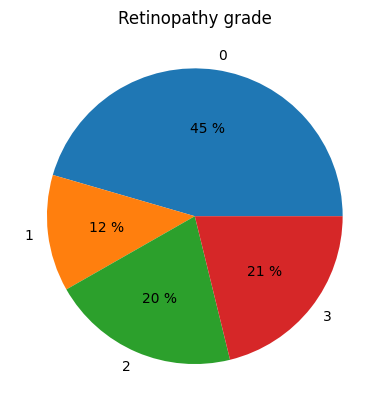

Retinopathy grade
0    546
1    153
2    247
3    254
Name: Image name, dtype: int64

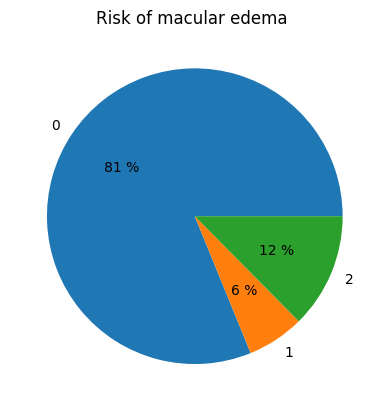

Risk of macular edema   Retinopathy grade
0                       0                    546
                        1                    142
                        2                    182
                        3                    104
1                       1                      5
                        2                     28
                        3                     42
2                       1                      6
                        2                     37
                        3                    108
Name: Image name, dtype: int64

In [20]:
dataframes = [pd.read_excel(messidor+f) for f in listdir(messidor) if f.endswith('.xls')]

df = pd.concat(dataframes)

plt.pie([df.loc[df['Retinopathy grade'] == n].count()[0] for n in range(4)], labels = range(4), autopct='%d %%')
plt.title("Retinopathy grade")
plt.show()
display(df.groupby('Retinopathy grade').count()['Image name'])

plt.pie([df.loc[df['Risk of macular edema '] == n].count()[0] for n in range(3)], labels = range(3), autopct='%d %%')
plt.title("Risk of macular edema ")
plt.show()
display(df.groupby(['Risk of macular edema ', 'Retinopathy grade']).count()['Image name'])

### Dataset to grade DR by classificaton

In [21]:
df = df.drop(columns=['Ophthalmologic department', 'Risk of macular edema '])

In [37]:
def organize_by_grades(dataf):
    return {f'{i}':list(dataf.loc[dataf[column] == i].pop('Image name')) for i in range(4)}

def organize_by_referability(dataf):
    grades = organize_by_grades(dataf)
    referability = {'referable':[], 'non-referable':[]}
    [referability['referable'].extend(grades[k]) if k == 1 or k == 2 else referability['non-referable'].extend(grades[k]) for k in grades.keys()]

    return referability

def organize_set(dataf, data_dir):
    for k in dataf.keys():
        mkdir(data_dir+f'{k}')
        for i, v in enumerate(dataf[k]):
            im_name = v.split('.')[0]
            im_name = f'{k}/{im_name}_{i}.jpg'
            im = cv2.imread(messidor+v)
            cv2.imwrite(data_dir+im_name, im)
            print(f"{im_name} saved")

#### Train

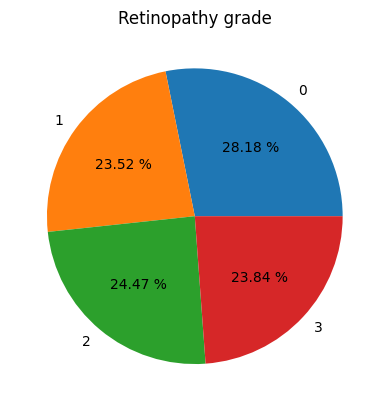

,Image name
Retinopathy grade,
0,357
1,298
2,310
3,302


,Image name
Retinopathy grade,
0,25
1,25
2,25
3,25


,Image name
Retinopathy grade,
0,25
1,25
2,25
3,25


In [24]:
training_df = df.groupby(column).sample(800, replace=True).copy(deep=True)

validation_df = training_df.groupby(column).sample(25)

training_df = training_df.drop(validation_df.index)

testing_df = df.groupby(column).sample(25)
testing_df.reset_index(drop=True, inplace=True)

validation_df.reset_index(drop=True, inplace=True)
training_df.reset_index(drop=True, inplace=True)

plt.pie([training_df.loc[training_df[column] == n].count()[0] for n in range(4)], labels = range(4), autopct='%.2f %%')
plt.title(column)
plt.show()

display(training_df.groupby(column).count())
display(validation_df.groupby(column).count())
display(testing_df.groupby(column).count())

In [32]:
!rm -r './Dataset_ref/'
!mkdir './Dataset_ref'

!rm -r './Dataset_grad/'
!mkdir './Dataset_grad'

In [33]:
train_dir_grad = './Dataset_grad/training/'
!mkdir './Dataset_grad/training/'

train_dir_ref = './Dataset_ref/training/'
!mkdir './Dataset_ref/training/'

train_ref = organize_by_referability(training_df)
train_grad = organize_by_grades(training_df)

organize_set(train_grad, train_dir_grad)
organize_set(train_ref, train_dir_ref)


0/20051130_54364_0400_PP_0.jpg saved
0/20051130_54301_0400_PP_1.jpg saved
0/20051130_54616_0400_PP_2.jpg saved
0/20051205_59833_0400_PP_3.jpg saved
0/20051201_38211_0400_PP_4.jpg saved
0/20060412_61665_0200_PP_5.jpg saved
0/20051130_60760_0400_PP_6.jpg saved
0/20060523_50342_0100_PP_7.jpg saved
0/20051205_57548_0400_PP_8.jpg saved
0/20060407_44766_0200_PP_9.jpg saved
0/20051110_38194_0400_PP_10.jpg saved
0/20051130_59775_0400_PP_11.jpg saved
0/20051020_58065_0100_PP_12.jpg saved
0/20051201_38199_0400_PP_13.jpg saved
0/20051130_59404_0400_PP_14.jpg saved
0/20051201_37390_0400_PP_15.jpg saved
0/20060407_41330_0200_PP_16.jpg saved
0/20051130_54498_0400_PP_17.jpg saved
0/20051201_38321_0400_PP_18.jpg saved
0/20051130_54077_0400_PP_19.jpg saved
0/20051130_54616_0400_PP_20.jpg saved
0/20051020_62510_0100_PP_21.jpg saved
0/20060530_53742_0100_PP_22.jpg saved
0/20060407_45362_0200_PP_23.jpg saved
0/20051020_44338_0100_PP_24.jpg saved
0/20051021_40018_0100_PP_25.jpg saved
0/20060407_46235_0200_

#### Testing

In [34]:
test_dir_grad = './Dataset_grad/testing/'
!mkdir './Dataset_grad/testing/'

test_dir_ref = './Dataset_ref/testing/'
!mkdir './Dataset_ref/testing/'

test_ref = organize_by_referability(testing_df)
test_grad = organize_by_grades(testing_df)

organize_set(test_grad, test_dir_grad)
organize_set(test_ref, test_dir_ref)

0/20060410_40381_0200_PP_0.jpg saved
0/20060412_61525_0200_PP_1.jpg saved
0/20051205_59754_0400_PP_2.jpg saved
0/20051020_61757_0100_PP_3.jpg saved
0/20051205_57757_0400_PP_4.jpg saved
0/20060411_58413_0200_PP_5.jpg saved
0/20051130_58921_0400_PP_6.jpg saved
0/20051205_57704_0400_PP_7.jpg saved
0/20060407_45834_0200_PP_8.jpg saved
0/20051021_51476_0100_PP_9.jpg saved
0/20051130_59964_0400_PP_10.jpg saved
0/20051201_38411_0400_PP_11.jpg saved
0/20060410_40846_0200_PP_12.jpg saved
0/20060523_45548_0100_PP_13.jpg saved
0/20051216_45992_0200_PP_14.jpg saved
0/20060523_48931_0100_PP_15.jpg saved
0/20051216_45595_0200_PP_16.jpg saved
0/20051110_38280_0400_PP_17.jpg saved
0/20060407_46235_0200_PP_18.jpg saved
0/20060410_45188_0200_PP_19.jpg saved
0/20051021_39482_0100_PP_20.jpg saved
0/20060523_49191_0100_PP_21.jpg saved
0/20051109_59864_0400_PP_22.jpg saved
0/20060410_43868_0200_PP_23.jpg saved
0/20060530_53597_0100_PP_24.jpg saved
1/20051216_45100_0200_PP_0.jpg saved
1/20060411_58971_0200_P

#### Validation

In [35]:
validation_dir_grad = './Dataset_grad/validation/'
!mkdir './Dataset_grad/validation/'

validation_dir_ref = './Dataset_ref/validation/'
!mkdir './Dataset_ref/validation/'

validation_ref = organize_by_referability(validation_df)
validation_grad = organize_by_grades(validation_df)

organize_set(validation_grad, validation_dir_grad)
organize_set(validation_ref, validation_dir_ref)

0/20051130_58874_0400_PP_0.jpg saved
0/20051130_58998_0400_PP_1.jpg saved
0/20060407_43856_0200_PP_2.jpg saved
0/20051110_33960_0400_PP_3.jpg saved
0/20051020_61804_0100_PP_4.jpg saved
0/20060410_39586_0200_PP_5.jpg saved
0/20051201_38280_0400_PP_6.jpg saved
0/20051205_59738_0400_PP_7.jpg saved
0/20051130_53663_0400_PP_8.jpg saved
0/20051130_55037_0400_PP_9.jpg saved
0/20051201_37462_0400_PP_10.jpg saved
0/20051201_38537_0400_PP_11.jpg saved
0/20051216_46156_0200_PP_12.jpg saved
0/20051130_54956_0400_PP_13.jpg saved
0/20051130_60585_0400_PP_14.jpg saved
0/20060529_56442_0100_PP_15.jpg saved
0/20051216_45595_0200_PP_16.jpg saved
0/20051110_37992_0400_PP_17.jpg saved
0/20060410_41098_0200_PP_18.jpg saved
0/20051020_44762_0100_PP_19.jpg saved
0/20051110_34071_0400_PP_20.jpg saved
0/20060523_50616_0100_PP_21.jpg saved
0/20051020_57157_0100_PP_22.jpg saved
0/20060412_61450_0200_PP_23.jpg saved
0/20051214_42363_0100_PP_24.jpg saved
1/20060410_47331_0200_PP_0.jpg saved
1/20060412_52997_0200_P